In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.core.display import display, HTML 
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

display(HTML("<style>.container { width: 100% !important; }</style>")) #넓이를 조정하는 작업을 진행하였습니다.
InteractiveShell.ast_node_interactivity = "all"
#%matplotlib qt5으로 표시가능

pd.set_option('max_columns',200,'max_rows', 2000,'display.max.colwidth', 1000)

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
# 최대 줄 수 설정
pd.set_option('display.max_rows', 500)
# 최대 열 수 설정
pd.set_option('display.max_columns', 500)
# 표시할 가로의 길이
pd.set_option('display.width', 1000)

# 0. 데이터 불러오기 및 주제 설명

안녕하세요 제가 ML과제로 도전해볼 과제는 "Instagram fake spammer genuine accounts" 라는 과제입니다.
이 데이터를 통하여 인스타그램의 유저가 스팸인지 아닌지 확인해 보고자 합니다. 
이 주제를 선택한 이유는 제가 공부하고 있는 도메인인 SNS 및 온라인 마케팅과 관련이 있다고 생각하였기 때문입니다. 
아직 많이 부족하지만 지금까지 투빅스에서 배운 내용을 활용하여 최선을 다해보도록 하겠습니다!

데이터의 출처는 캐글을 활용하였습니다. 캐글에서는 train.csv와 test.csv를 구분하여 제공하고 있습니다.

프로필만 가지고 판단하는 것이 얼마나 신뢰할 수 있을까 벌써부터 의문이 들지만 한번 해보도록 하겠습니다..
출처: https://www.kaggle.com/free4ever1/instagram-fake-spammer-genuine-accounts

먼저 train과 test 데이터를 불러오도록 하겠습니다. 

In [2]:
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv") 

In [3]:
train.head()
train.info()
train.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,posts,followers,follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 12 columns):
profile pic             576 non-null int64
nums/length username    576 non-null float64
fullname words          576 non-null int64
nums/length fullname    576 non-null float64
name==username          576 non-null int64
description length      576 non-null int64
external URL            576 non-null int64
private                 576 non-null int64
posts                   576 non-null int64
followers               576 non-null int64
follows                 576 non-null int64
fake                    576 non-null int64
dtypes: float64(2), int64(10)
memory usage: 54.1 KB


,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,posts,followers,follows,fake
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,5.760000e+02,576.000000,576.000000
mean,0.701389,0.163837,1.460069,0.036094,0.034722,22.623264,0.116319,0.381944,107.489583,8.530724e+04,508.381944,0.500000
std,0.458047,0.214096,1.052601,0.125121,0.183234,37.702987,0.320886,0.486285,402.034431,9.101485e+05,917.981239,0.500435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.900000e+01,57.500000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.505000e+02,229.500000,0.500000
75%,1.000000,0.310000,2.000000,0.000000,0.000000,34.000000,0.000000,1.000000,81.500000,7.160000e+02,589.500000,1.000000
max,1.000000,0.920000,12.000000,1.000000,1.000000,150.000000,1.000000,1.000000,7389.000000,1.533854e+07,7500.000000,1.000000


데이터의 구성을 확인해 보도록 하겠습니다. 

|변수명|설명|
|-|-|
|profile pic|프로필에 사진이 있는지 여부를 1과 0으로 나타냈습니다. 
nums/length username|사용자 이름에 포함된 숫자 문자의 길이 비율
fullname words|full name 단어 갯수
nums/length fullname|전체 이름의 숫자 문자 수에 대한 길이 비율
name==username|username과 실제 이름의 일치여부
description length|프로필 설명의 길이
external URL|프로필에 외부 URL이 있는지 여부
private posts|계정이 공개인지 비공개인지(팔로잉을 해야 게시글을 볼수있는지)
followers|팔로워 수
follows |팔로잉 수
fake|스팸계정인지 아닌지

와 같이 구성되어 있습니다. 이번 과제의 목표는 follows fake를 예측하는 것으로 정하고 진행해보도록 하겠습니다. 

- 사진의 유무는 0.701389로 사진이 있는경우가 더 많은 것을 확인할 수 있었습니다. 
- Username과 실제 이름이 일치하는 경우는 평균이 0.034722로 거의 없음을 확인할 수 있었습니다. 
- 평균 프로필 설명의 길이는 22.623264로 확인할 수 있었습니다. 
- 외부 URL이 있는 경우 보다 없는 경우가 더 많은 것을 확인할 수 있었습니다. 
- 개정이 비공개 계정인 경우보다 공개인 계정의 경우가 많은 것을 확인할 수 있었습니다. 
- 평균적으로 팔로워의 평균보다 팔롱잉의 평균이 많은 것을 확인 할 수 있었습니다. 
- follows fake의 1대 1로 구성되어있어 밸런스한 data라고 판단하였습니다. 

# 1.전처리 및 EDA

In [4]:
train.isnull().head() #결측치가 있는지 없는지 확인하는 방법(개별적으로 존재유무 확인)
train.isnull().sum(axis=1).head(10) #결측치의 총합

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,posts,followers,follows,fake
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

결측치는 존재하지 않는 것으로 확인되었습니다. 

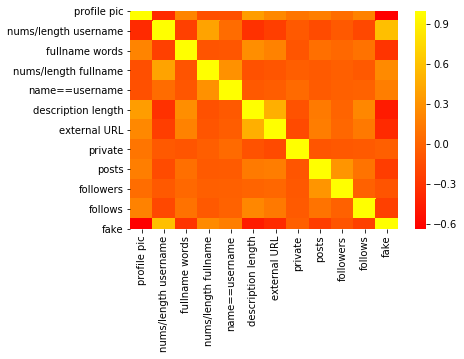

In [5]:
sns.heatmap(train.corr(),cmap='autumn')

히트맵을 그려봤을 때, 아쉽게도 엄청난 상관관계가 보이는 관계는 찾을 수 없었습니다. 너무 아쉽습니다

In [6]:
train.corr()['fake'].sort_values()

profile pic            -0.637315
description length     -0.460825
external URL           -0.362809
fullname words         -0.298793
posts                  -0.245355
follows                -0.224835
followers              -0.093689
private                -0.028586
name==username          0.170695
nums/length fullname    0.246782
nums/length username    0.587687
fake                    1.000000
Name: fake, dtype: float64

fake에 대해서 상관계수를 확인해 보았을때
사진의 여부가 뚜렷한 음의 상관관계를, username의 숫자 비중이 양의 상관관계를 가지고 있음을 확인할 수 있었습니다.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017399AA6A08>,
      dtype=object)

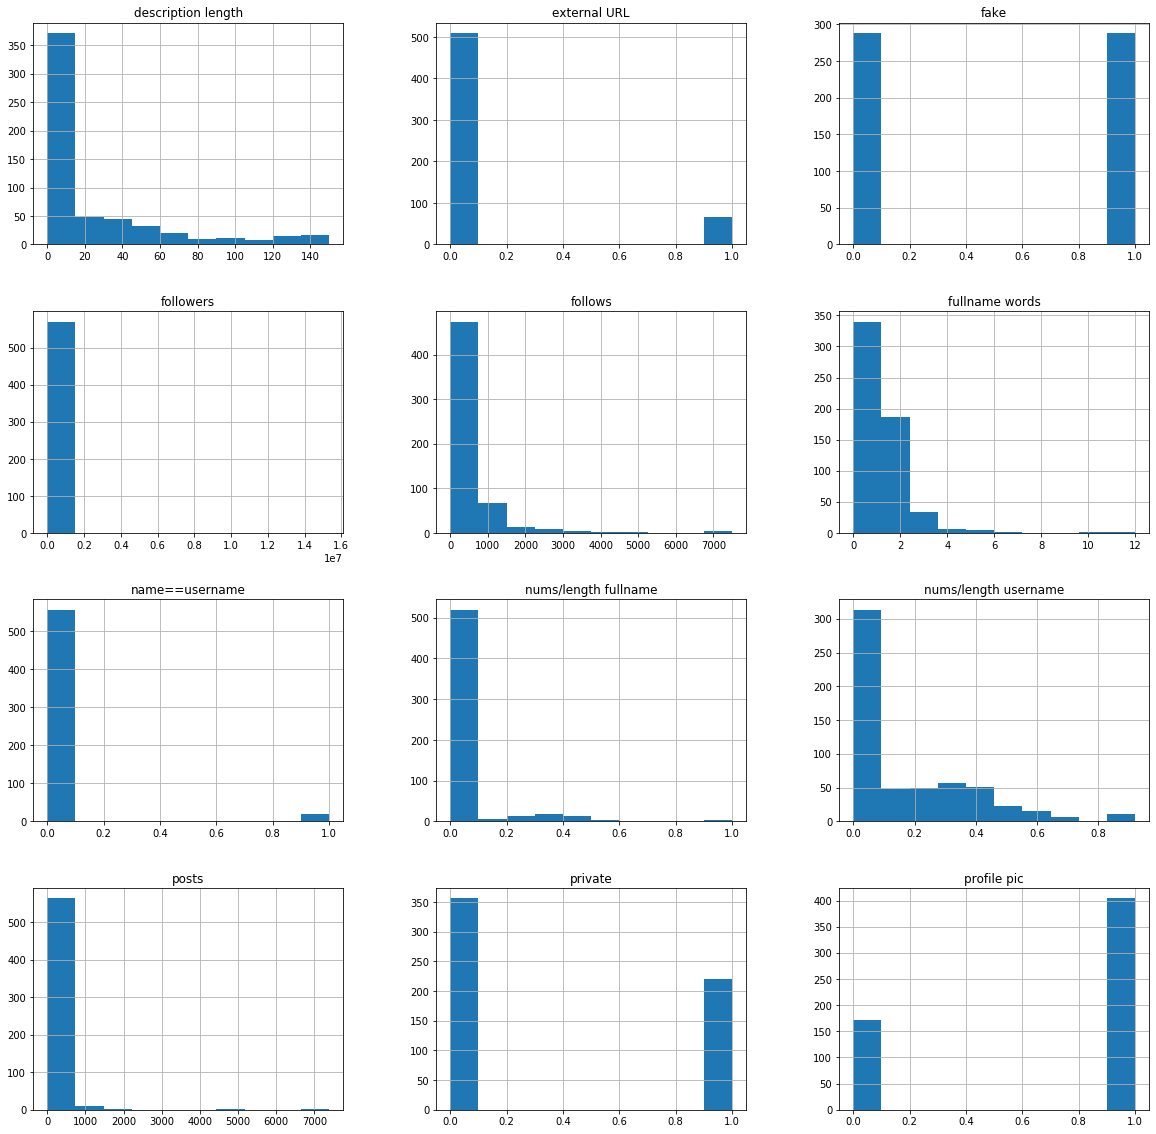

In [7]:
train.hist(bins=10,figsize=(20,20))

다음은 변수들에 대해서 스케일링을 진행하도록 하겠습니다. 

In [8]:
train_y = pd.DataFrame(train['fake'])
continuous = pd.DataFrame(train[['nums/length username','fullname words','nums/length fullname','description length', 'posts','followers','follows']])
train_x = train.drop(['nums/length username','fullname words','nums/length fullname','description length', 'posts','followers','follows','fake'],axis=1)

In [9]:
scaler = StandardScaler()
scaler.fit(continuous) 
continuous_scale = scaler.transform(continuous) #연속형에 대해서만 스케일링을 진행하고
continuous_scale = pd.DataFrame(continuous_scale,columns=['nums/length username','fullname words','nums/length fullname','description length', 'posts','followers','follows'])
x_train_scale = pd.concat([train_x,continuous_scale], axis=1) #다시 하나의 train_x로 concat해 주었습니다. 
np.mean(x_train_scale), np.std(x_train_scale)


StandardScaler(copy=True, with_mean=True, with_std=True)

(profile pic             7.013889e-01
 name==username          3.472222e-02
 external URL            1.163194e-01
 private                 3.819444e-01
 nums/length username    2.618469e-16
 fullname words         -8.621576e-16
 nums/length fullname    1.331882e-16
 description length      1.613871e-15
 posts                  -2.665692e-16
 followers              -6.507622e-17
 follows                -8.129107e-17
 dtype: float64, profile pic             0.457649
 name==username          0.183075
 external URL            0.320608
 private                 0.485863
 nums/length username    1.000000
 fullname words          1.000000
 nums/length fullname    1.000000
 description length      1.000000
 posts                   1.000000
 followers               1.000000
 follows                 1.000000
 dtype: float64)

In [10]:
x_train_scale.head() #다음과 같이 scaling된 데이터를 확인할 수 있습니다. 

,profile pic,name==username,external URL,private,nums/length username,fullname words,nums/length fullname,description length,posts,followers,follows
0,1,0,0,0,0.496299,-1.388312,-0.288723,0.806385,-0.187932,-0.092711,0.486945
1,1,0,0,0,-0.765916,0.513395,-0.288723,0.567470,0.444404,-0.090797,0.026841
2,1,0,0,1,-0.298429,0.513395,-0.288723,-0.600561,-0.235233,-0.093636,-0.447437
3,1,0,0,0,-0.765916,-0.437459,-0.288723,1.576224,1.422782,-0.093355,0.155496
4,1,0,0,1,-0.765916,0.513395,-0.288723,-0.600561,-0.252659,-0.093644,-0.416909


같은 방식으로 test 데이터에 대해서도 스케일링을 진행하였습니다. 

In [11]:
test_y = pd.DataFrame(test['fake'])
continuous = pd.DataFrame(test[['nums/length username','fullname words','nums/length fullname','description length', 'posts','followers','follows']])
test_x = test.drop(['nums/length username','fullname words','nums/length fullname','description length', 'posts','followers','follows','fake'],axis=1)

In [12]:
continuous_scale=scaler.transform(continuous) #trainsform한뒤
continuous_scale = pd.DataFrame(continuous_scale,columns=['nums/length username','fullname words','nums/length fullname','description length', 'posts','followers','follows'])
x_test_scale = pd.concat([test_x,continuous_scale], axis=1) #다시 하나로 concat해 주었습니다. 

# 2. 나이브 베이즈

나이브 베이즈는 분류기를 만들 수 있는 간단한 방법입니다. 모든 나이브 베이즈 분류기는 공통적으로 모든 특성 값은 서로 독립임을 가정하고 진행합니다.
예를 들어, 특정 과일을 사과로 분류 가능하게 하는 특성들 (둥글다, 빨갛다, 지름 10cm)은 나이브 베이즈 분류기에서 특성들 사이에서 발생할 수 있는 연관성이 없음을 가정하고 각각의 특성들이 특정 과일이 사과일 확률에 독립적으로 기여 하는 것으로 판단합니다. 

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [14]:
gnb = GaussianNB() #gnb라는 이름으로 불러오고
y_pred = gnb.fit(x_train_scale,train_y)#fitting 시키기

In [15]:
y_pred.predict(x_test_scale) 

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [16]:
gnb.score(x_test_scale,test_y) #점수확인(실망스러운 점수입니다...ㅠ)

0.6916666666666667

# 3 로지스틱 회귀분석

로지스틱 회귀의 목적은 일반적인 회귀 분석의 목표와 동일하게 종속 변수와 독립 변수간의 관계를 구체적인 함수로 나타내어 향후 예측 모델에 사용하는 방법입니다
카테고리를 0과 1로 나누어 판단하기 때문에 스팸 계정을 판단하기 위한 방법으로 알맞다고 판단하여 사용하였습니다. 

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score


logreg = LogisticRegression().fit(x_train_scale, train_y) #logreg라는 이름으로 로지스틱회귀를 만들고 적합하였습니다. 

In [18]:
y_pred = logreg.predict(x_test_scale) # class에대해서 예측해 보도록하겠습니다. 
y_pred

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

In [19]:
logreg.score(x_test_scale, test_y) #나이브베이즈보다는 좋은 점수를 나타내는 것을 확인할 수 있습니다. 

0.8833333333333333

In [20]:
#gridSearch를 활용하여 파라미터를 조절하고 다시한번 시행해 보았습니다. 
from sklearn.model_selection import GridSearchCV


param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']} # 파라메터에 대한 후보를 만들었습니다. 


grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5) # 로지스틱회귀 그리드 서치를 진행하였습니다. 

grid_search.fit(x_train_scale, train_y) #적합시킨후에
grid_search.score(x_test_scale, test_y) #점수를 확인하였습니다. 
#Accuracy가 크게 차이나지 않는 것으로 나타났습니다. 

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

0.8666666666666667

In [21]:
print(confusion_matrix(grid_search.predict(x_test_scale), test_y))
print(classification_report(grid_search.predict(x_test_scale), test_y))
#f-1 score, matrix, #정확도, 재현율

[[52  8]
 [ 8 52]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        60
           1       0.87      0.87      0.87        60

    accuracy                           0.87       120
   macro avg       0.87      0.87      0.87       120
weighted avg       0.87      0.87      0.87       120



1) 스팸이 아닌데, 스팸이 아니라고 판단한 경우 = 52 건

2) 스팸이 아닌데, 스팸이라고 판단한 경우 = 8건

3) 스팸인데, 스팸이 아니라고 판단한 경우 = 8건

4) 스팸인데, 스팸이라고 판단한 경우 = 52건으로 나타났습니다.

5) Precision의 경우 0경우와 1인 경우는 모두 0.87의 정밀도를 보였습니다.

6) Recall의 경우는 0.87의 재현율을 보였습니다.

7) 이를 통해 f1-score를 봤을때 0.87의 점수를 나타냈습니다.

In [22]:
scores = cross_val_score(logreg, x_train_scale, train_y, cv=3) # model, train, target, cross validation

print('cross-val-score \n{}'.format(scores))

print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

cross-val-score 
[0.89583333 0.85416667 0.953125  ]
cross-val-score.mean 
0.901


CV를 해봤을 때 평균 score가 0.901로 나타나는 것을 확인할 수 있었습니다. 
(cutoff를 찾아서 다시설정했으면 어떻게 되었을까요...?)

# 4. 앙상블

앙상블 학습은 여러 개의 모델을 결합하여 하나의 모델보다 더 좋은 성능을 내는 머신러닝 기법입니다.
앙상블 학습의 핵심은 여러 개의 약 분류기 (Weak Classifier)를 결합하여 강 분류기(Strong Classifier)를 만드는 것입니다.
그리하여 모델의 정확성이 향상됩니다

In [23]:
#Validation function를 만듭니다
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train_scale.values)
    rmse= np.sqrt(-cross_val_score(model, x_train_scale.values, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## 4.1 Lasso

In [24]:
lasso=Lasso(alpha =0.0001,random_state=1).fit(x_train_scale, train_y)

In [25]:
lasso.score(x_train_scale,train_y)
lasso.score(x_test_scale,test_y)

0.6074065805056786

0.5415311916598575

민망한 점수입니다... 
alpha를 줄이면 가장 낮은 오차를 찾아가는 반복횟수가 늘어나야 합니다. 따라서 max_iter를 증가시켜야 합니다.

alpha와max_iter값에 따른 Lasso결과를 시각화 해보겠습니다.

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x17399f03cc8>,
 <a list of 3 Text xticklabel objects>)

Text(0, 0.617, '0.607')

Text(0.35, 0.552, '0.542')

Text(1, 0.606, '0.596')

Text(1.35, 0.562, '0.552')

Text(2, 0.01, '0.0')

Text(2.35, 0.01, '0.0')

Text(0.5, 0, 'alpha')

Text(0, 0.5, 'score')

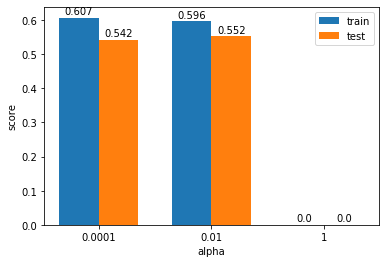

In [26]:
import matplotlib.pyplot as plt



alpha_set = [0.0001, 0.01, 1]

max_inter_set = [10000000, 100000, 1000]



train_score = []

test_score = []

used_feature = []



for a, m in zip(alpha_set, max_inter_set):

    lasso = Lasso(alpha=a, max_iter=m).fit(x_train_scale, train_y)

    la_tr_score = round(lasso.score(x_train_scale, train_y), 3)

    la_te_score = round(lasso.score(x_test_scale, test_y), 3)

    number_used = np.sum(lasso.coef_ != 0)



    train_score.append(la_tr_score)

    test_score.append(la_te_score)

    used_feature.append(number_used)



index = np.arange(len(alpha_set))

bar_width = 0.35

plt.bar(index, train_score, width=bar_width, label='train')

plt.bar(index+bar_width, test_score, width=bar_width, label='test')

plt.xticks(index+bar_width/2, alpha_set) # bar그래프 dodge를 하기 위해 기준값에 보정치를 더해줍니다.



for i, (ts, te) in enumerate(zip(train_score, test_score)):

    plt.text(i, ts+0.01, str(ts), horizontalalignment='center')

    plt.text(i+bar_width, te+0.01, str(te), horizontalalignment='center')



plt.legend(loc=1)

plt.xlabel('alpha')

plt.ylabel('score')

plt.show()

음... 넘어가도록 하겠습니다.

# 4.2 GBoost

In [27]:
GBoost = GradientBoostingRegressor(n_estimators=100, criterion='friedman_mse', max_depth=3, max_leaf_nodes=None, min_samples_split=2, min_samples_leaf=1, max_features=None) ## 알아서 한번 최적의 파라미터를 찾아보시게나~~ 

In [28]:
GBoost=GBoost.fit(x_train_scale,train_y)
GBoost.score(x_test_scale,test_y)

0.7593994461131592

In [29]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.2563 (0.1043)



## 4.5 xgb

In [30]:
xgb = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100,300,500,1000]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(x_train_scale,
         train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done  72 out of  72 | elapsed:    9.1s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_weight': [4],
                         'n_estim

0.0
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [32]:
model_xgb = xgb
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[21:34:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:34:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:34:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:34:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:34:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:34:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:34:21] WARNI

In [33]:
model_xgb.fit(x_train_scale,train_y)
model_xgb.score(x_test_scale,test_y)

[21:34:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

0.7700012317930882

## 4.6 light gbm

In [34]:
# coding: utf-8
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [35]:
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=500)
gbm.fit(x_train_scale, train_y)
model_lgb = gbm 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [36]:
model_lgb.score(x_test_scale,test_y)

0.7948079897239756

In [37]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.2557 (0.1014)



In [44]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [47]:
averaged_models = AveragingModels(models = [logreg, model_xgb
,model_lgb
]) ## 모델 뭐쓸래))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[21:40:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:40:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:40:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:40:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:40:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:40:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:40:14] WARNI

In [56]:
averaged_models.fit(x_train_scale,train_y)
averaged_models.score(x_test_scale,test_y)

[21:42:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


AveragingModels(models=[LogisticRegression(C=1.0, class_weight=None, dual=False,
                                           fit_intercept=True,
                                           intercept_scaling=1, l1_ratio=None,
                                           max_iter=100, multi_class='auto',
                                           n_jobs=None, penalty='l2',
                                           random_state=None, solver='lbfgs',
                                           tol=0.0001, verbose=0,
                                           warm_start=False),
                        XGBRegressor(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsam...
                        LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                          

0.7610967675919521

앙상블 결과는 대체적으로 좋지 못하게 나오는 것을 알 수 있었습니다. 